<a href="https://colab.research.google.com/github/funtodaramola/Early-stage-diabetes-risk-prediction-using-Logistic-Regression/blob/main/Early_Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries



In [23]:

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import classification_report, confusion_matrix

Importing Dataset

In [64]:
rawData = pd.read_csv('diabetes_data_upload.csv')
rawData.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


<h2>Preprocessing data</h2>

In [65]:
binaryData  = rawData.replace(to_replace=['No', 'Yes'], value=[0, 1]) # Replacing categorical data with numerical data
binaryData = pd.concat([binaryData, pd.get_dummies(binaryData['Gender'])], axis=1) # One hot encoding of 'Gender' features 
label_encoder = LabelEncoder()
binaryData["label"] = label_encoder.fit_transform(binaryData["class"]) # Label encoding of classes
binaryData.drop(["Gender", "class"], axis=1, inplace=True) # Dropping of redundant features 
binaryData.head()

,Age,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,Female,Male,label
0,40,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1
1,58,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1
2,41,1,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1,1
3,45,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,1,1
4,60,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1


In [66]:
binaryData.describe() # This  shows that the 'Age' feature is of a different scale to the rest of the data

,Age,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,Female,Male,label
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,48.028846,0.496154,0.448077,0.417308,0.586538,0.455769,0.223077,0.448077,0.486538,0.242308,0.459615,0.430769,0.375000,0.344231,0.169231,0.369231,0.630769,0.615385
std,12.151466,0.500467,0.497776,0.493589,0.492928,0.498519,0.416710,0.497776,0.500300,0.428892,0.498846,0.495661,0.484589,0.475574,0.375317,0.483061,0.483061,0.486973
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
#checking for outliers
z = np.abs(stats.zscore(binaryData))
outliers = list(set(np.where(z > 3)[0]))

len(outliers)

4

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


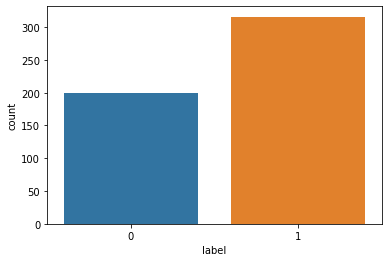

In [68]:
binaryData = binaryData.drop(outliers,axis = 0).reset_index(drop = False) #dropping outliers
sns.countplot(binaryData["label"]) # Checking for class imbalance

Normalization of 'Age' feature

In [69]:
X = binaryData.drop(['label', 'Age'], axis = 1) # independent variable
y = binaryData[['label']] #dependent variable

age = binaryData[['Age']]
X = pd.DataFrame(X, columns = X.columns) #converting scaled data into dataframe
y = pd.DataFrame(y, columns = y.columns) #ideally train, test data should be in columns

min_max_scaler = preprocessing.MinMaxScaler()
ageScaled = min_max_scaler.fit_transform(age)
ageNorm = pd.DataFrame(ageScaled)
ageNorm.columns =['Age'] 
normX = pd.concat([X, ageNorm], axis=1)
normX.describe() #now the min and max values are all 0 <= X >= 1

,index,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,Female,Male,Age
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,260.399225,0.496124,0.443798,0.412791,0.587209,0.455426,0.217054,0.443798,0.482558,0.244186,0.459302,0.430233,0.370155,0.343023,0.170543,0.368217,0.631783,0.503538
std,150.442659,0.500470,0.497313,0.492814,0.492814,0.498492,0.412640,0.497313,0.500181,0.430020,0.498825,0.495589,0.483315,0.475180,0.376474,0.482789,0.482789,0.185492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.365079
50%,261.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.492063
75%,390.250000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.634921
max,519.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
#check for missing values
normX = normX.drop('index', axis = 1)
normX.isna().sum()

Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
Female                0
Male                  0
Age                   0
dtype: int64

In [71]:
#Split into train, test set

# X_train, X_test, y_train,y_test = train_test_split(normX, y, test_size = 0.2, random_state = 14)
X_train, X_test, y_train, y_test = train_test_split(normX, y, test_size=0.3, random_state=1, stratify=y)


In [72]:
# Use of k fold cross validation 
model = LogisticRegression(random_state=14, n_jobs=-1)
cv = cross_validate(model, X_train, y_train, cv = 10, n_jobs=-1, return_estimator=True)


print("Mean training accuracy: {}".format(np.mean(cv['test_score'])))
print("Test accuracy: {}".format(cv["estimator"][0].score(X_test, y_test)))

Mean training accuracy: 0.9029279279279278
Test accuracy: 0.9483870967741935


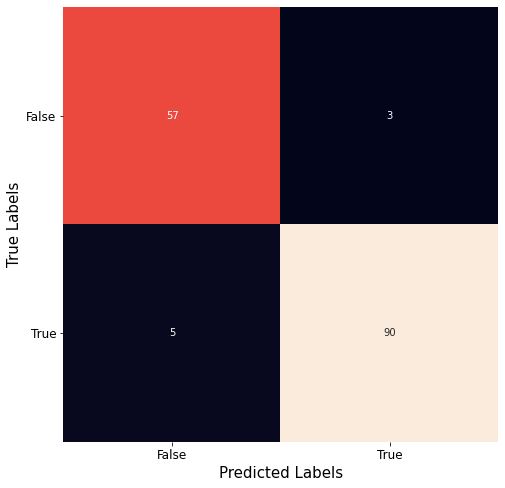

In [73]:
# Use of confusion matrix due to class imbalance
pred = cv["estimator"][0].predict(X_test)

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(12, 8))
ax =sns.heatmap(cm, square=True, annot=True, cbar=False)
ax.xaxis.set_ticklabels(["False","True"], fontsize = 12)
ax.yaxis.set_ticklabels(["False","True"], fontsize = 12, rotation=0)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()

In [74]:
print(classification_report(y_test, cv["estimator"][0].predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        60
           1       0.97      0.95      0.96        95

    accuracy                           0.95       155
   macro avg       0.94      0.95      0.95       155
weighted avg       0.95      0.95      0.95       155



In [75]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

final_model = cv["estimator"][0]

y_pred = final_model.predict(X_test)

print("Accuracy:",accuracy_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Recall:",recall_score(y_test,y_pred))
print("F1 Score:",f1_score(y_test,y_pred))

Accuracy: 0.9483870967741935
Precision: 0.967741935483871
Recall: 0.9473684210526315
F1 Score: 0.9574468085106383
